# Task
The file contains data of 2 produced parts, which are already spatially matched
- part1: partname=demo with sensor Temp
- part2: partname=demoCT with sensor Density

Each line represents a voxel in space with the corresponding sensor values:
maxX, maxY, maxZ, minX, minY, minZ 
describe the geometry of the voxels

To reduce data the following features are generated per voxel:
- Avg: Average of all sensor values in this cube
- Min: Minimum value of all sensor values in this voxel
- Max: Maximum value of all sensor values in this voxel
- Count: Number of sensor values in this voxel
- Sum: Sum of all sensor values in this voxel
- SumSquared: Squared sum of all sensor values in this voxel

The tags column indicates, which of the sensor features are valid. If no value is given, all sensor features are valid.
tags: “partname=demo” means only sensor features of the first part are available in this voxel, which can be seen on the count feature for the second part.

### Typical use cases from industry
<div style="display:flex;">
    <div style="flex:1;">
        <p>
            Part1 (tags: partname=demo or no tag) is produced via 3d printing. Complex geometries require a support structure, which is later removed again.
            For better understanding, this is a visualization of the component, where yellow indicates roughly the primary structure:
            <br><br>Part1 (temp features) contains sensor data from the production of the component (process data). 
            <br><br>Part2 (density features) contains sensor data from the quality control (quality data).
        </p>
    </div>
    <div style="flex:1;">
        <img src="./image.png" alt="printer" width="500">
    </div>
</div>

### Requirements
- Is there any relationship between the process and the quality data?
- Can you label each voxel and check if it is part of the supporting structure or if it is part of the primary structure?


## Setup

In [156]:
import pandas as pd
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import preprocessing
import re
from scipy.stats import pearsonr

# Preset matplotlib figure sizes
matplotlib.rcParams['figure.figsize'] = [9, 6]

## Read Data

In [129]:
# Read CSV file and create a DataFrame
df = pd.read_csv('AI_test_cubesize3.csv', delimiter=',')
# check shape and columns names
df.shape

(16049, 19)

In [130]:
df.columns

Index(['maxX', 'maxY', 'maxZ', 'minX', 'minY', 'minZ', 'tags', 'AvgTemp',
       'MinTemp', 'MaxTemp', 'CountTemp', 'SumTemp', 'SumsquaredTemp',
       'AvgDensity', 'MinDensity', 'MaxDensity', 'CountDensity', 'SumDensity',
       'SumsquaredDensity'],
      dtype='object')

In [131]:
df.describe(include='all')

maxX          maxY          maxZ          minX          minY  \
count   16049.000000  16049.000000  16049.000000  16049.000000  16049.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.089271    -11.852987   -219.351101     -1.620375    -13.556553   
std        35.545840     23.543563     30.997463     35.509612     23.477831   
min       -65.203058    -71.561194   -279.028711    -65.587137    -72.477532   
25%       -30.396245    -29.389023   -245.414028    -31.454041    -31.435849   
50%        -5.616055    -10.732986   -222.357265     -6.290181    -12.580989   
75%        29.291647      4.188907   -195.047357     27.265381      2.121294   
max        79.126281     42.404238   -150.905459     77.650911     42.160820   

                minZ           tags       AvgTemp        MinTemp  \
count   16049.000000          10005  16049.000000   1.604900e+04   
unique           NaN              2           NaN            NaN   
top              NaN  partname=demo           NaN            NaN   
freq             NaN           9657           NaN            NaN   
mean     -221.027707            NaN    781.846643            inf   
std        30.963318            NaN    287.040183            inf   
min      -279.779688            NaN      0.000000   4.262877e+01   
25%      -247.410767            NaN    603.850341   1.225577e+02   
50%      -224.375611            NaN    740.254277   2.291297e+02   
75%      -197.095755            NaN    946.559580   4.156306e+02   
max      -150.952808            NaN   2014.209591  1.797693e+308   

              MaxTemp     CountTemp        SumTemp  SumsquaredTemp  \
count    1.604900e+04  16049.000000   16049.000000    1.604900e+04   
unique            NaN           NaN            NaN             NaN   
top               NaN           NaN            NaN             NaN   
freq              NaN           NaN            NaN             NaN   
mean     1.273398e+03     83.829211   77787.057996    8.639774e+07   
std      5.050070e+02     62.393814   75854.240940    1.063372e+08   
min     2.225074e-308      0.000000       0.000000    0.000000e+00   
25%      1.001776e+03     26.000000   17078.152753    1.223932e+07   
50%      1.161634e+03     75.000000   55859.680284    4.596960e+07   
75%      1.614565e+03    131.000000  107291.296625    1.028572e+08   
max      2.973357e+03    202.000000  336959.147425    6.776994e+08   

          AvgDensity     MinDensity     MaxDensity  CountDensity  \
count   16049.000000   1.604900e+04   1.604900e+04  16049.000000   
unique           NaN            NaN            NaN           NaN   
top              NaN            NaN            NaN           NaN   
freq             NaN            NaN            NaN           NaN   
mean       69.022886            inf   8.864440e+01    114.008910   
std        85.279106            inf   1.093144e+02    188.865941   
min         0.000000   3.000000e+00  2.225074e-308      0.000000   
25%         0.000000   9.000000e+00  2.225074e-308      0.000000   
50%         0.000000  1.797693e+308  2.225074e-308      0.000000   
75%       173.328185  1.797693e+308   2.240000e+02    174.000000   
max       228.000000  1.797693e+308   2.380000e+02    550.000000   

          SumDensity  SumsquaredDensity  
count   16049.000000       1.604900e+04  
unique           NaN                NaN  
top              NaN                NaN  
freq             NaN                NaN  
mean    19861.534488       3.735254e+06  
std     33023.212626       6.229346e+06  
min         0.000000       0.000000e+00  
25%         0.000000       0.000000e+00  
50%         0.000000       0.000000e+00  
75%     29916.000000       5.567861e+06  
max     97829.000000       1.902211e+07

In [132]:
df[df['tags'] == 'partname=demo'].head(2)

maxX      maxY        maxZ       minX      minY        minZ  \
0  76.126198  9.078488 -158.662013  75.503577  8.429608 -159.381064   
1  78.176057  5.759926 -158.729964  77.626201  4.745554 -159.337157   

            tags      AvgTemp     MinTemp      MaxTemp  CountTemp  \
0  partname=demo  1158.081705  735.346359  1561.278863         15   
1  partname=demo  1327.760945  815.275311  1854.351687         17   

        SumTemp  SumsquaredTemp  AvgDensity     MinDensity     MaxDensity  \
0  17371.225577    2.166742e+07         0.0  1.797693e+308  2.225074e-308   
1  22571.936057    3.244258e+07         0.0  1.797693e+308  2.225074e-308   

   CountDensity  SumDensity  SumsquaredDensity  
0             0           0                  0  
1             0           0                  0

In [133]:
df[df['tags'] == 'partname=demoCT'].head(2)

maxX      maxY        maxZ       minX      minY        minZ  \
475  50.305144  6.067394 -167.599102  50.033611  4.471827 -167.756052   
476  50.273419  4.070828 -167.416059  49.841297  2.203226 -167.749527   

                tags  AvgTemp        MinTemp        MaxTemp  CountTemp  \
475  partname=demoCT      0.0  1.797693e+308  2.225074e-308          0   
476  partname=demoCT      0.0  1.797693e+308  2.225074e-308          0   

     SumTemp  SumsquaredTemp  AvgDensity  MinDensity  MaxDensity  \
475      0.0             0.0  192.166667       173.0       206.0   
476      0.0             0.0  173.785714        15.0       221.0   

     CountDensity  SumDensity  SumsquaredDensity  
475             6        1153             222427  
476            14        2433             458527

In [134]:
df[df['tags'].isna()].head(2)

maxX       maxY        maxZ       minX     minY        minZ tags  \
323  70.939372   1.959731 -150.905459  69.535174  0.25941 -150.994314  NaN   
324  77.440158  10.103740 -159.496913  75.509902  8.39254 -161.428702  NaN   

         AvgTemp     MinTemp      MaxTemp  CountTemp       SumTemp  \
323   617.356001  495.559503   735.346359          7   4321.492007   
324  1120.235005  602.131439  1667.850799         65  72815.275311   

     SumsquaredTemp  AvgDensity  MinDensity  MaxDensity  CountDensity  \
323    2.713127e+06  214.000000       214.0       214.0             1   
324    8.696227e+07  169.357143         6.0       215.0            42   

     SumDensity  SumsquaredDensity  
323         214              45796  
324        7113            1328279

<Axes: xlabel='tags', ylabel='count'>

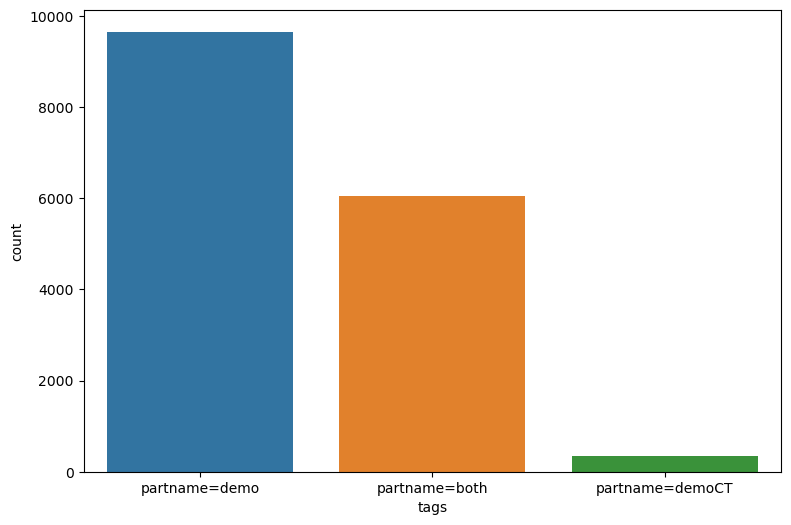

In [135]:
# replace NaN with Unknown label
df['tags'] = df['tags'].fillna('partname=both')

sns.countplot(x = 'tags', data=df)

The figure suggests that we have unbalanced classes, however, will proceed with the assumption that it will not be relevant for the task at hand.

# Temperature (Process) vs Density (Quality)

The columns related to temperature and density are only used to avoid relying on tags or position for analysis. 

In [136]:
# choose only the columns related to temp and density
pattern = r".*(Temp|Density)$"

train_df = df[[col for col in df.columns if re.match(pattern=pattern, string=col)]]

train_df.columns

Index(['AvgTemp', 'MinTemp', 'MaxTemp', 'CountTemp', 'SumTemp',
       'SumsquaredTemp', 'AvgDensity', 'MinDensity', 'MaxDensity',
       'CountDensity', 'SumDensity', 'SumsquaredDensity'],
      dtype='object')

Text(0.5, 1.0, 'Temperature Density Correlation Matrix')

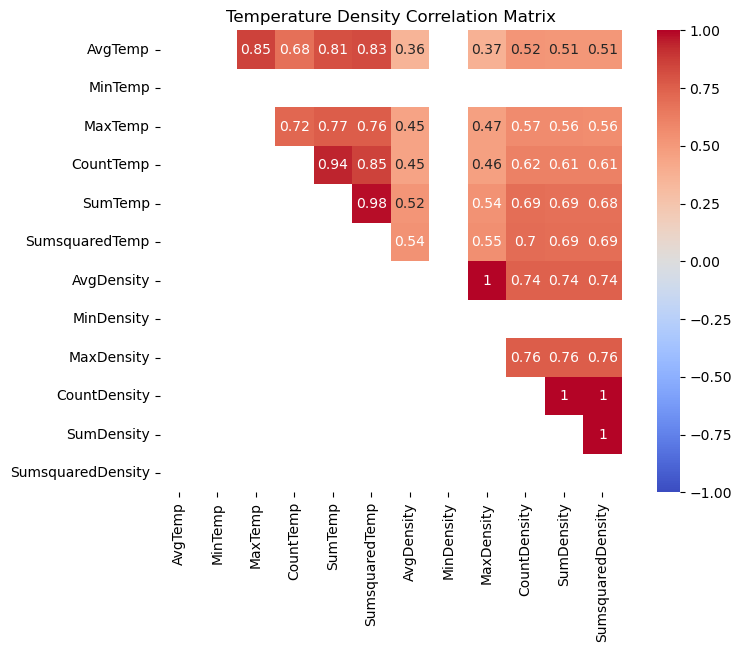

In [137]:
correlation_matrix = train_df.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, square=True)

plt.title('Temperature Density Correlation Matrix')

The correlation matrix shows a relatively strong positive linear relationship between the temp and density.

<Axes: xlabel='AvgDensity', ylabel='AvgTemp'>

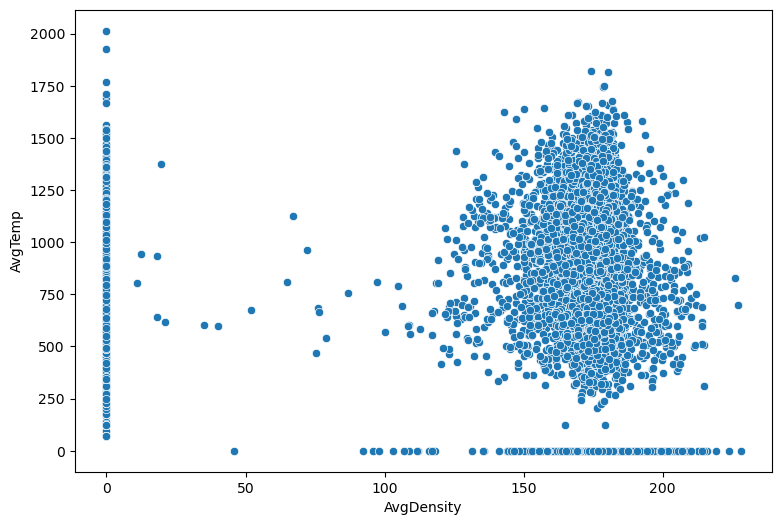

In [138]:
sns.scatterplot(data = temp_density_df, x = 'AvgDensity', y = 'AvgTemp')

Scatter plot confirms the relationship between avg density and avg temp. The two clusters at zero temp and zero density represent the cases when the sensor measurement is not available.

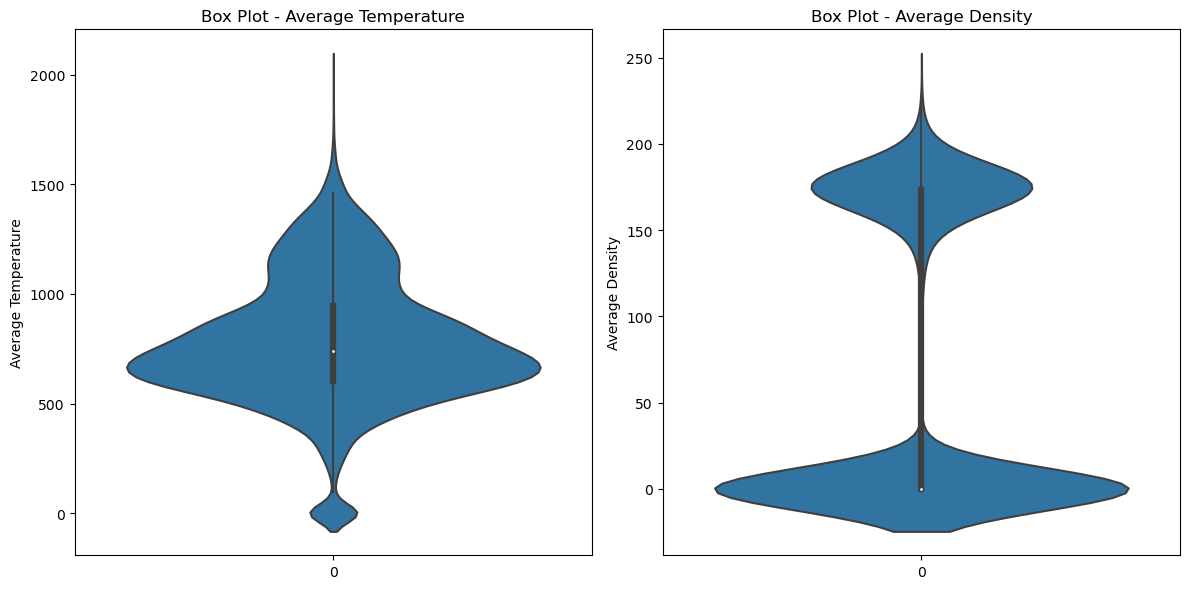

In [139]:
# Set the figure size and create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Average Temperature
sns.violinplot(data=df['AvgTemp'], ax=axes[0])
axes[0].set_ylabel('Average Temperature')
axes[0].set_title('Box Plot - Average Temperature')

# Plot 2: Average Density
sns.violinplot(data=df['AvgDensity'], ax=axes[1])
axes[1].set_ylabel('Average Density')
axes[1].set_title('Box Plot - Average Density')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

This suggests we have a bimodal distribution for the density, unlike the temperature.

## Pearson Correlation Test AvgTemp vs. AvgDensity

In [157]:
# Perform Pearson correlation test
correlation, p_value = pearsonr(train_df['AvgDensity'], train_df['AvgTemp'])

# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
print("p-value:", p_value)

# Set the significance level (alpha)
alpha = 0.05

# Interpret the results
if p_value < alpha:
    if correlation > 0:
        print("There is a significant positive correlation between average density and average temperature.")
    elif correlation < 0:
        print("There is a significant negative correlation between average density and average temperature.")
else:
    print("There is no significant correlation between average density and average temperature.")


Correlation coefficient: 0.3557994274116651
p-value: 0.0
There is a significant positive correlation between average density and average temperature.


It is the case that the correlation between some temp and density columns is larger than the above value, but that might go back to the fact that they are confounding variables, for example `SumTemp, SumsquaredTemp`.

# Primary vs. Supporting Structure

## K-Means Clustering on Position, Density, Temp
For this part, I will procedd with the hypothesis that only position and density is needed to determine if the voxel is primary or supporting. I will perform unsupervised clustering into two groups primary and support.

In [141]:
pattern = r".*(X|Y|Z|Density|Temp)$"

train_df = df[[col for col in df.columns if re.match(pattern=pattern, string=col)]]

In [142]:
# normalize the data
X_train_norm = preprocessing.normalize(train_df)

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(X_train_norm)

# Get the cluster labels
kmeans_labels = kmeans.labels_

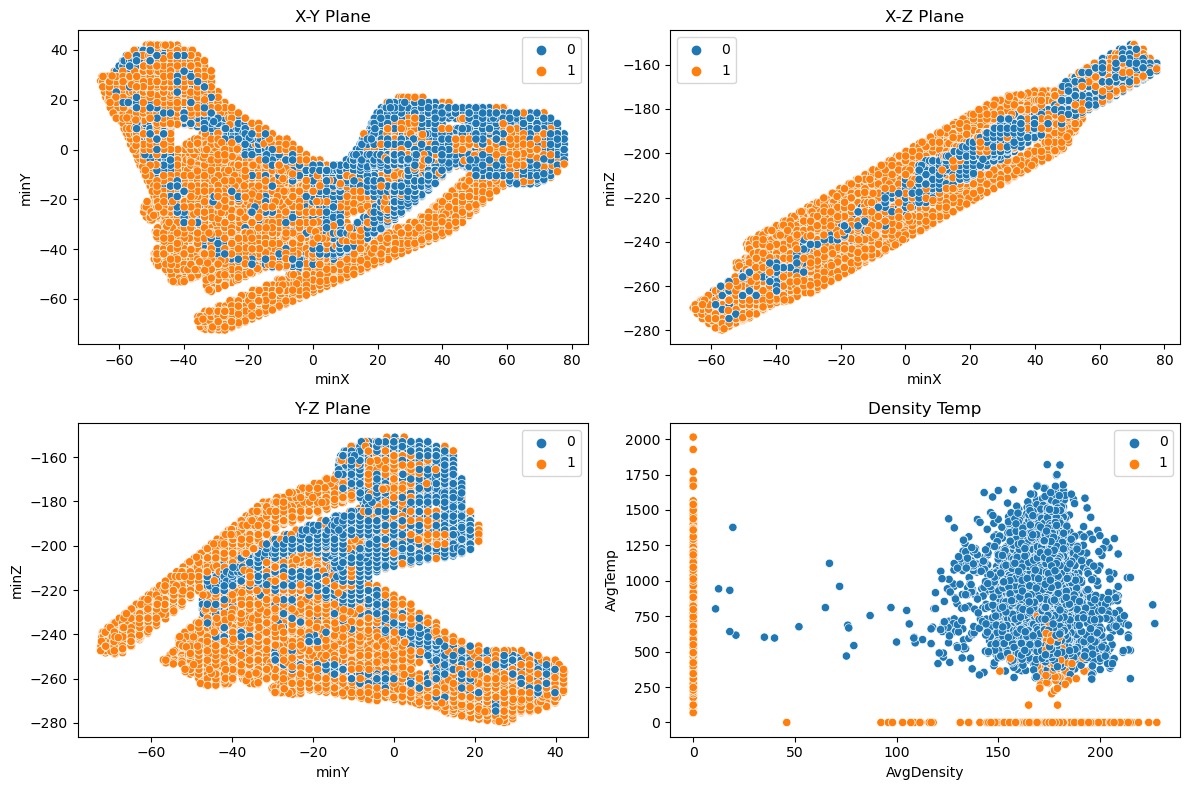

In [143]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Plot 1
plt.subplot(2, 2, 1)
sns.scatterplot(data=train_df, x='minX', y='minY', hue=kmeans_labels)
plt.title('X-Y Plane')

# Plot 2
plt.subplot(2, 2, 2)
sns.scatterplot(data=train_df, x='minX', y='minZ', hue=kmeans_labels)
plt.title('X-Z Plane')

# Plot 3
plt.subplot(2, 2, 3)
sns.scatterplot(data=train_df, x='minY', y='minZ', hue=kmeans_labels)
plt.title('Y-Z Plane')

# Plot 4
plt.subplot(2, 2, 4)
sns.scatterplot(data=train_df, x='AvgDensity', y='AvgTemp', hue=kmeans_labels)
plt.title('Density Temp')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [144]:
import plotly.express as px
fig = px.scatter_3d(data_frame=train_df, x='minX', y='minY', z='minZ', color=labels)

fig.show()

## K-Means Clustering on Position Only

In [145]:
pattern = r".*(X|Y|Z)$"

train_df = df[[col for col in df.columns if re.match(pattern=pattern, string=col)]]

In [146]:
# normalize the data
X_train_norm = preprocessing.normalize(train_df)

kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(X_train_norm)

# Get the cluster labels
kmeans_labels_pos_only = kmeans.labels_

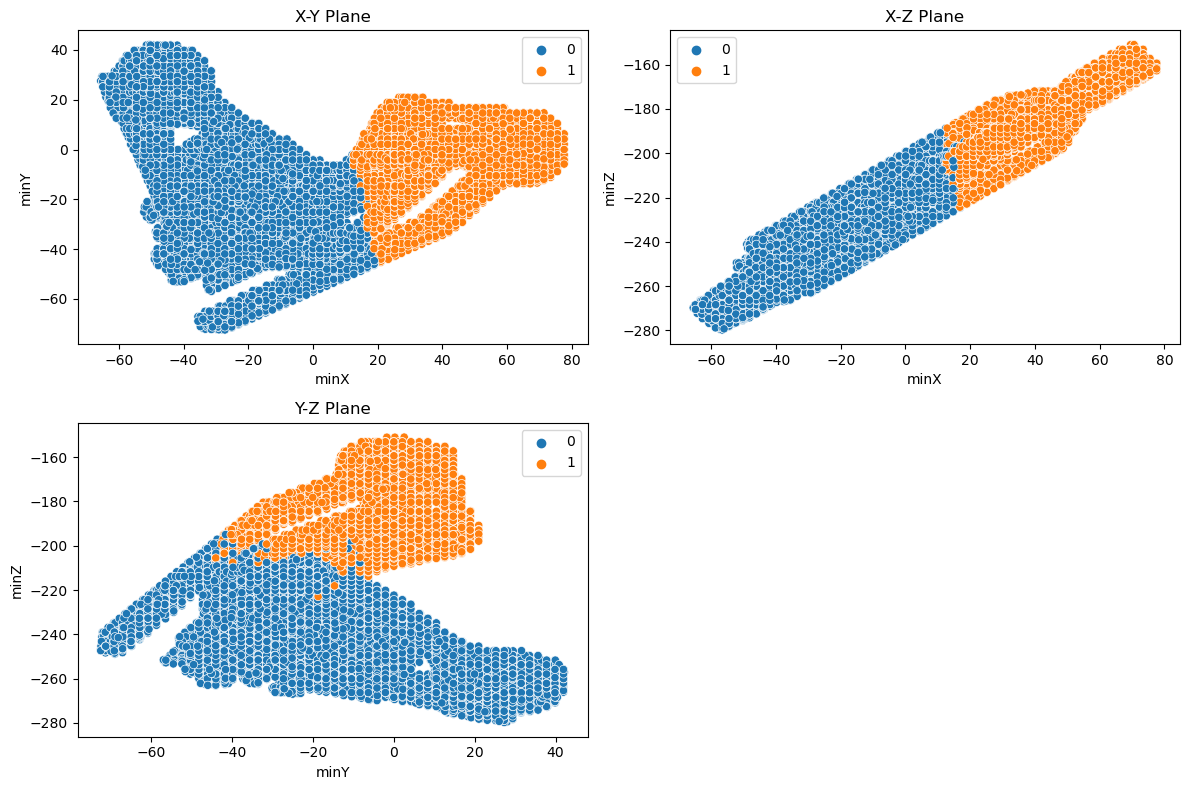

In [147]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Plot 1
plt.subplot(2, 2, 1)
sns.scatterplot(data=train_df, x='minX', y='minY', hue=kmeans_labels_pos_only)
plt.title('X-Y Plane')

# Plot 2
plt.subplot(2, 2, 2)
sns.scatterplot(data=train_df, x='minX', y='minZ', hue=kmeans_labels_pos_only)
plt.title('X-Z Plane')

# Plot 3
plt.subplot(2, 2, 3)
sns.scatterplot(data=train_df, x='minY', y='minZ', hue=kmeans_labels_pos_only)
plt.title('Y-Z Plane')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [148]:
import plotly.express as px
fig = px.scatter_3d(data_frame=train_df, x='minX', y='minY', z='minZ', color=labels)

fig.show()

## Hierarchical Clustering on Position, Density, Temp

In [149]:
pattern = r".*(X|Y|Z|Density|Temp)$"

train_df = df[[col for col in df.columns if re.match(pattern=pattern, string=col)]]

In [150]:
# normalize the data
X_train_norm = preprocessing.normalize(train_df)

hclustering = AgglomerativeClustering(n_clusters=2).fit(X_train_norm)

# Get the cluster labels
hclustering_labels = hclustering.labels_

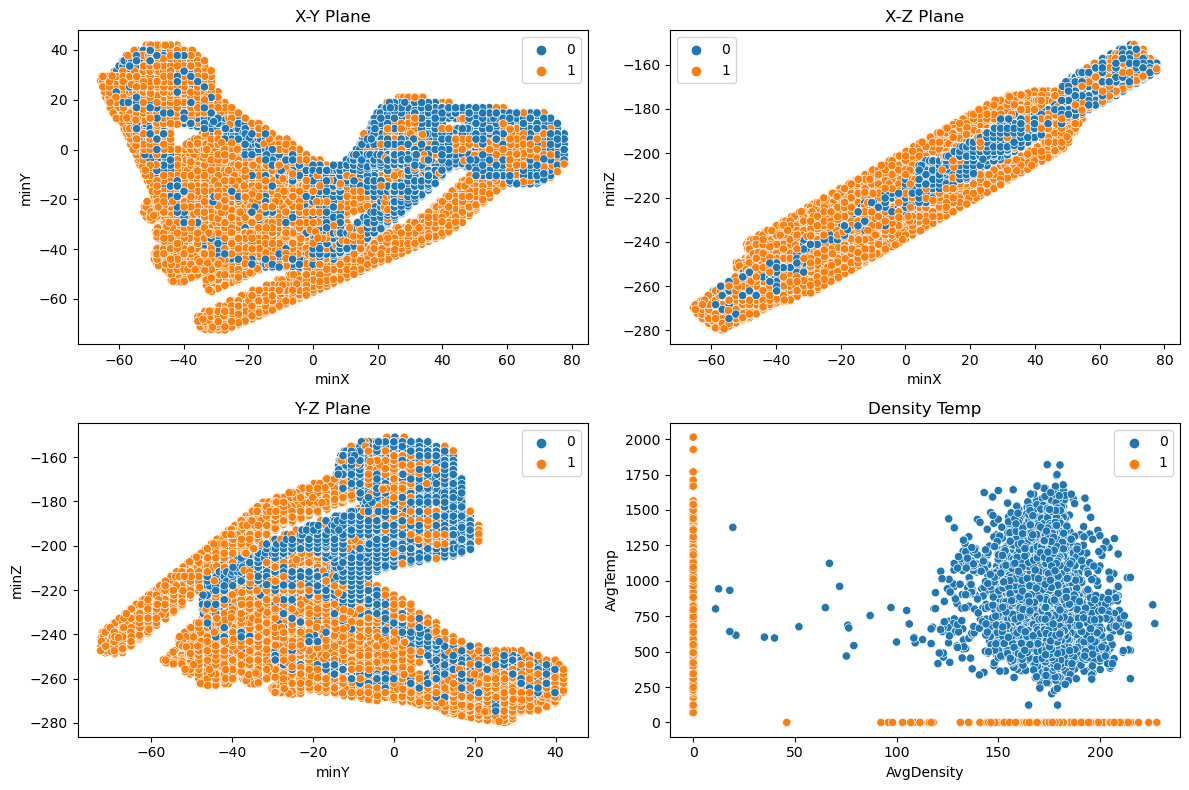

In [151]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Plot 1
plt.subplot(2, 2, 1)
sns.scatterplot(data=train_df, x='minX', y='minY', hue=hclustering_labels)
plt.title('X-Y Plane')

# Plot 2
plt.subplot(2, 2, 2)
sns.scatterplot(data=train_df, x='minX', y='minZ', hue=hclustering_labels)
plt.title('X-Z Plane')

# Plot 3
plt.subplot(2, 2, 3)
sns.scatterplot(data=train_df, x='minY', y='minZ', hue=hclustering_labels)
plt.title('Y-Z Plane')

# Plot 4
plt.subplot(2, 2, 4)
sns.scatterplot(data=train_df, x='AvgDensity', y='AvgTemp', hue=hclustering_labels)
plt.title('Density Temp')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [152]:
import plotly.express as px
fig = px.scatter_3d(data_frame=train_df, x='minX', y='minY', z='minZ', color=labels)

fig.show()

# K-Means vs. Hierarchical Clustering

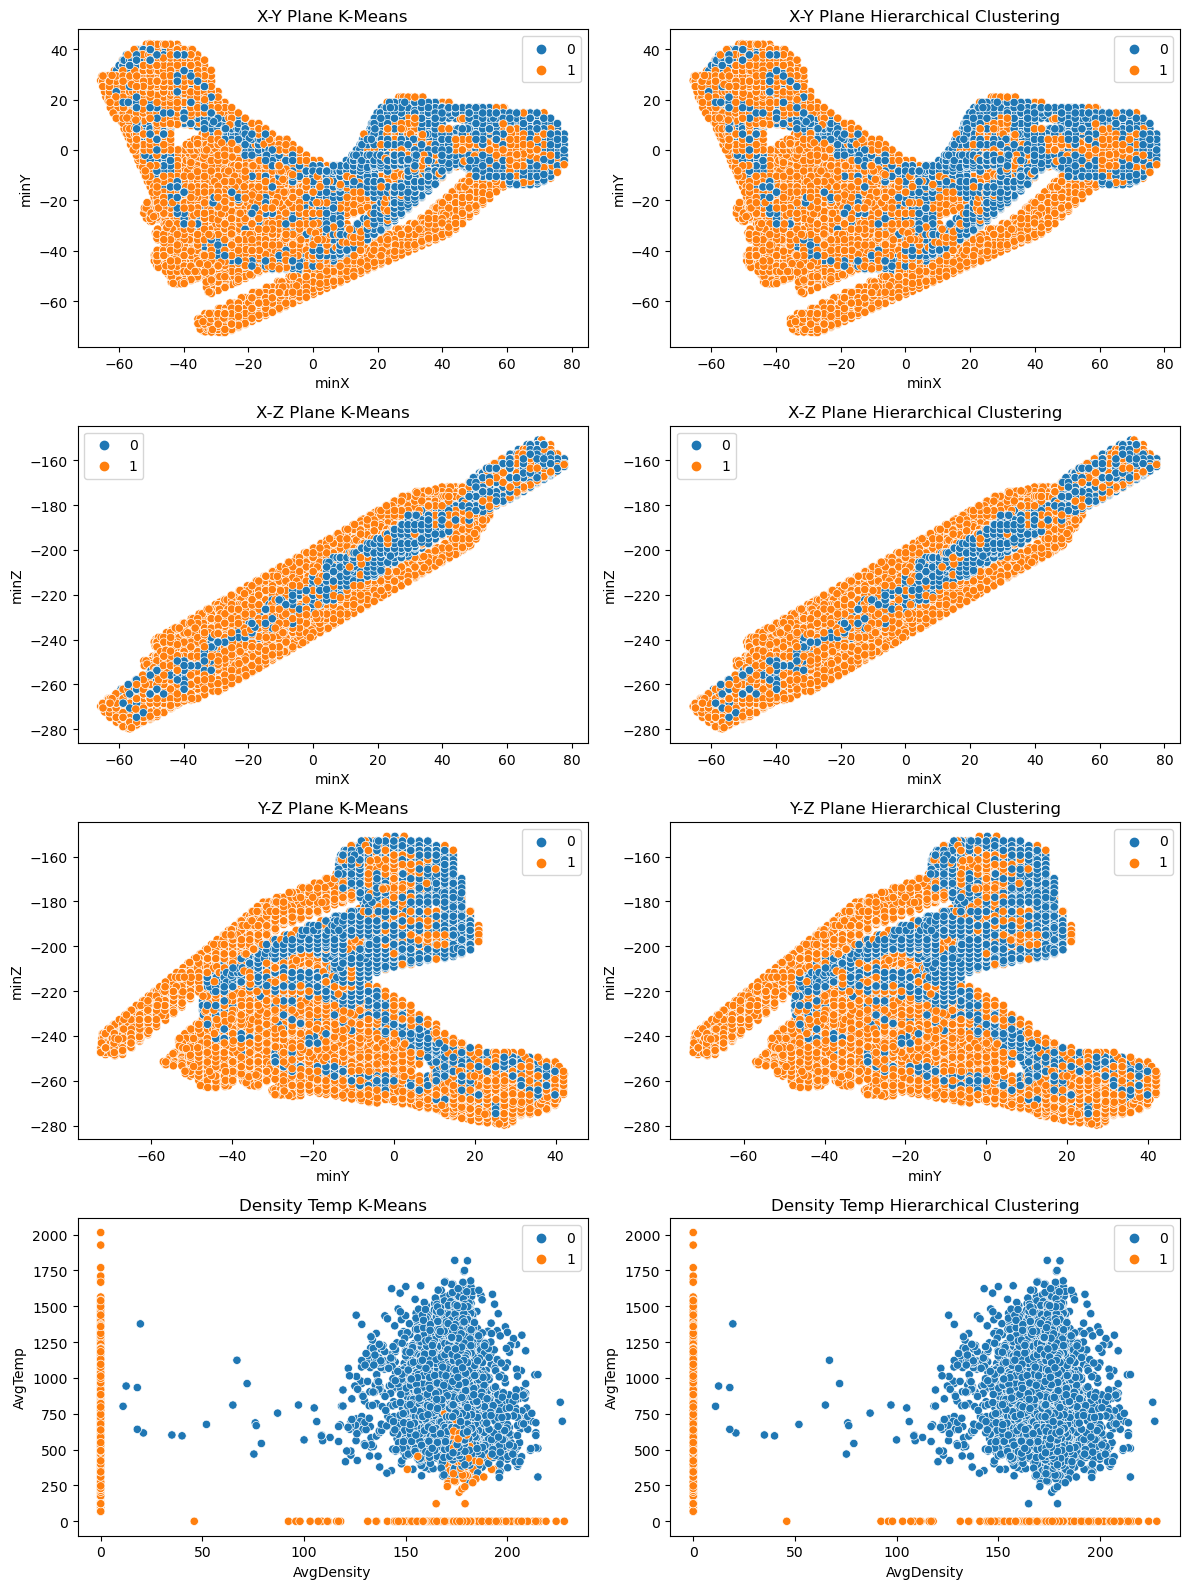

In [155]:
# Set the figure size
plt.figure(figsize=(12, 16))

# Plot 1
plt.subplot(4, 2, 1)
sns.scatterplot(data=train_df, x='minX', y='minY', hue=kmeans_labels)
plt.title('X-Y Plane K-Means')

# Plot 2
plt.subplot(4, 2, 2)
sns.scatterplot(data=train_df, x='minX', y='minY', hue=kmeans_labels)
plt.title('X-Y Plane Hierarchical Clustering')

# Plot 3
plt.subplot(4, 2, 3)
sns.scatterplot(data=train_df, x='minX', y='minZ', hue=hclustering_labels)
plt.title('X-Z Plane K-Means')

# Plot 4
plt.subplot(4, 2, 4)
sns.scatterplot(data=train_df, x='minX', y='minZ', hue=hclustering_labels)
plt.title('X-Z Plane Hierarchical Clustering')

plt.subplot(4, 2, 5)
sns.scatterplot(data=train_df, x='minY', y='minZ', hue=kmeans_labels)
plt.title('Y-Z Plane K-Means')

plt.subplot(4, 2, 6)
sns.scatterplot(data=train_df, x='minY', y='minZ', hue=hclustering_labels)
plt.title('Y-Z Plane Hierarchical Clustering')

plt.subplot(4, 2, 7)
sns.scatterplot(data=train_df, x='AvgDensity', y='AvgTemp', hue=kmeans_labels)
plt.title('Density Temp K-Means')

plt.subplot(4, 2, 8)
sns.scatterplot(data=train_df, x='AvgDensity', y='AvgTemp', hue=hclustering_labels)
plt.title('Density Temp Hierarchical Clustering')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Conclusion

Clustering on `position, density, temperature` provides better results for the given task, unlike using `position` only. The clustering algorithm used provide slightly different output, however, not by a large margin. Further exploration of the output when using `Autoencoder` and then applying `K-Means` on latent space could be a potential solution.

One important aspect also is considering which features to be used, for the multi temp, density columns have confounding variables. Also, understanding the data more will help and provide more insights.

For a more sophisticated classification or clustering, 3D models could be leveraged in order to use knowledge priors from 3D objects or 2D images.